In [7]:
import newspaper
import pandas as pd
from tqdm import auto
import ray
from newspaper import Article, Config
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0'
config = Config()
config.browser_user_agent = USER_AGENT
# ray.init()

In [2]:
@ray.remote
def get_article(url):
    try:
        article = Article(url, config=config)
        article.download()
        article.parse()
        article.text
        article.title
        return [article.title, article.text]
    except:
        return []


In [3]:
def parmap(f, list):
    return [f.remote(x) for x in list]

In [4]:
df = pd.read_csv('http://data.gdeltproject.org/gdeltv2/masterfilelist.txt',sep=" ", names=['id', 'hash', 'file'])

In [5]:
df['split'] = df.file.str.split('/')

In [6]:
df.split.sample(2)

413418    [http:, , data.gdeltproject.org, gdeltv2, 2019...
685671    [http:, , data.gdeltproject.org, gdeltv2, 2021...
Name: split, dtype: object

In [7]:
valid = df[df.split.apply(lambda x: type(x)) == type([])]

In [8]:
valid.loc[:,'sub_split'] = valid.split.apply(lambda x: x[-1].split('.'))

/Users/hhoferic/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [9]:
valid.loc[:,'ts'] = valid.sub_split.apply(lambda x: x[0])
valid.loc[:,'type'] = valid.sub_split.apply(lambda x: x[1])

In [10]:
ts_valid = valid.sort_values('ts', ascending=False).set_index('ts')

In [54]:
# extracts = []
shuffeled_index = ts_valid.sample(frac=1).index
for _id, index in enumerate(auto.tqdm(shuffeled_index)):
    ts_current = ts_valid.loc[index]

    ts_current_export = ts_current[ts_current.type == 'export']
    ts_current_mentions = ts_current[ts_current.type == 'mentions']

    try:
        df_export = pd.read_csv(
            ts_current_export.file.values[0], 
            compression='zip', 
            sep ='\t', 
            header=None, 
            usecols=[0,56,57,60], 
            names=['id', 'lat', 'lon', 'url']
        )

        df_mentions = pd.read_csv(
            ts_current_mentions.file.values[0], 
            compression='zip', sep ='\t', 
            header=None, 
            usecols=[0, 5, 11], 
            names=['id', 'url_2', 'conf']
        )
    except:
        continue

    df_join = df_export.set_index('id').join(df_mentions.set_index('id'))
    df_join = df_join[df_join['url'] == df_join['url_2']]
    df_join = df_join.drop(columns='url_2')
    df_join = df_join[df_join.conf >= 90]
    df_join = df_join.dropna(subset=['lat', 'lon'])
    df_join = df_join.drop_duplicates(subset=['lat', 'lon', 'url'])
    articles = ray.get(parmap(get_article, df_join.url.values))
    df_join.loc[:,'articles'] = articles 

    extracts.append(df_join)
    
    if _id%50 == 0:
        all_extracts = pd.concat(extracts)
        all_extracts.to_parquet('data/gdelt_extracts.parquet')



  0%|          | 0/693242 [00:00<?, ?it/s]

(get_article pid=4528) 
(get_article pid=4529) 
(get_article pid=4535) 
(get_article pid=4535) 
(get_article pid=4525) 
(get_article pid=4531) 
(get_article pid=4525) 
(get_article pid=4530) 
(get_article pid=4525) 
(get_article pid=4533) 
(get_article pid=4525) 


KeyboardInterrupt: 

In [55]:
all_extracts = pd.concat(extracts)
all_extracts.to_parquet('data/gdelt_extracts.parquet')

In [56]:
all_extracts.loc[:, 'lat'] = pd.to_numeric(all_extracts.lat)
all_extracts.loc[:, 'lon'] = pd.to_numeric(all_extracts.lon)

In [57]:
# all_extracts = all_extracts.drop_duplicates(subset=['lat', 'lon'])

<AxesSubplot:xlabel='lon', ylabel='lat'>

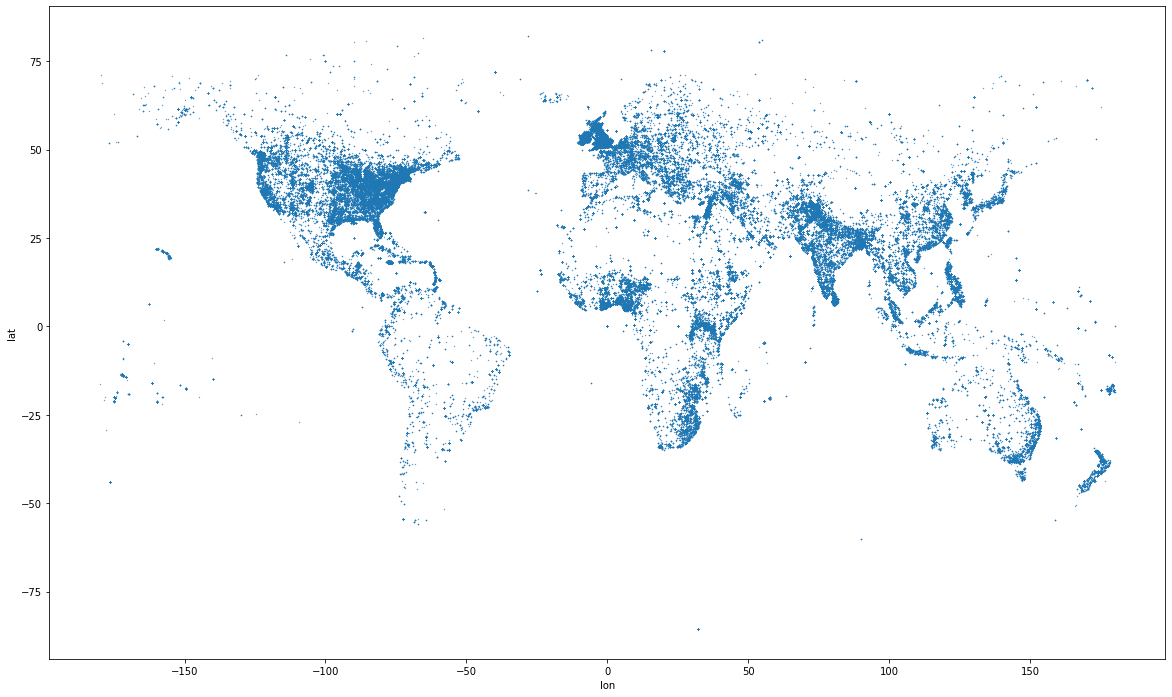

In [58]:
all_extracts.plot.scatter(x='lon', y='lat', figsize = (20,12), s=0.1)

In [62]:
wiki_dat = pd.read_parquet('data/wiki_geo_data.parquet')

In [31]:
wiki_dat.shape

NameError: name 'wiki_dat' is not defined

In [69]:
@ray.remote
def concat_text(_list):
     return " ".join(_list)

In [72]:
text = ray.get(parmap(concat_text, all_extracts.articles))

(concat_text pid=4525) 
(concat_text pid=4528) 
(concat_text pid=4528) 
(concat_text pid=4528) 
(concat_text pid=4530) 
(concat_text pid=4533) 
(concat_text pid=4524) 
(concat_text pid=4530) 
(concat_text pid=4533) 
(concat_text pid=4535) 
(concat_text pid=4525) 
(concat_text pid=4530) 
(concat_text pid=4530) 
(concat_text pid=4535) 
(concat_text pid=4531) 
(concat_text pid=4536) 
(concat_text pid=4531) 
(concat_text pid=4534) 
(concat_text pid=4535) 
(concat_text pid=4526) 
(concat_text pid=4526) 
(concat_text pid=4527) 
(concat_text pid=4528) 
(concat_text pid=4527) 
(concat_text pid=4535) 
(concat_text pid=4525) 
(concat_text pid=4531) 
(concat_text pid=4527) 
(concat_text pid=4534) 
(concat_text pid=4536) 
(concat_text pid=4536) 
(concat_text pid=4524) 
(concat_text pid=4524) 
(concat_text pid=4527) 
(concat_text pid=4534) 
(concat_text pid=4531) 
(concat_text pid=4535) 
(concat_text pid=4524) 
(concat_text pid=4527) 
(concat_text pid=4524) 
(concat_text pid=4528) 
(concat_text pid

In [74]:
all_extracts.loc[:, 'text'] = text

In [78]:
df_union = pd.concat([wiki_dat, all_extracts[['text', 'lat', 'lon']]])

In [80]:
df_union = df_union.sample(frac=1)

<AxesSubplot:xlabel='lon', ylabel='lat'>

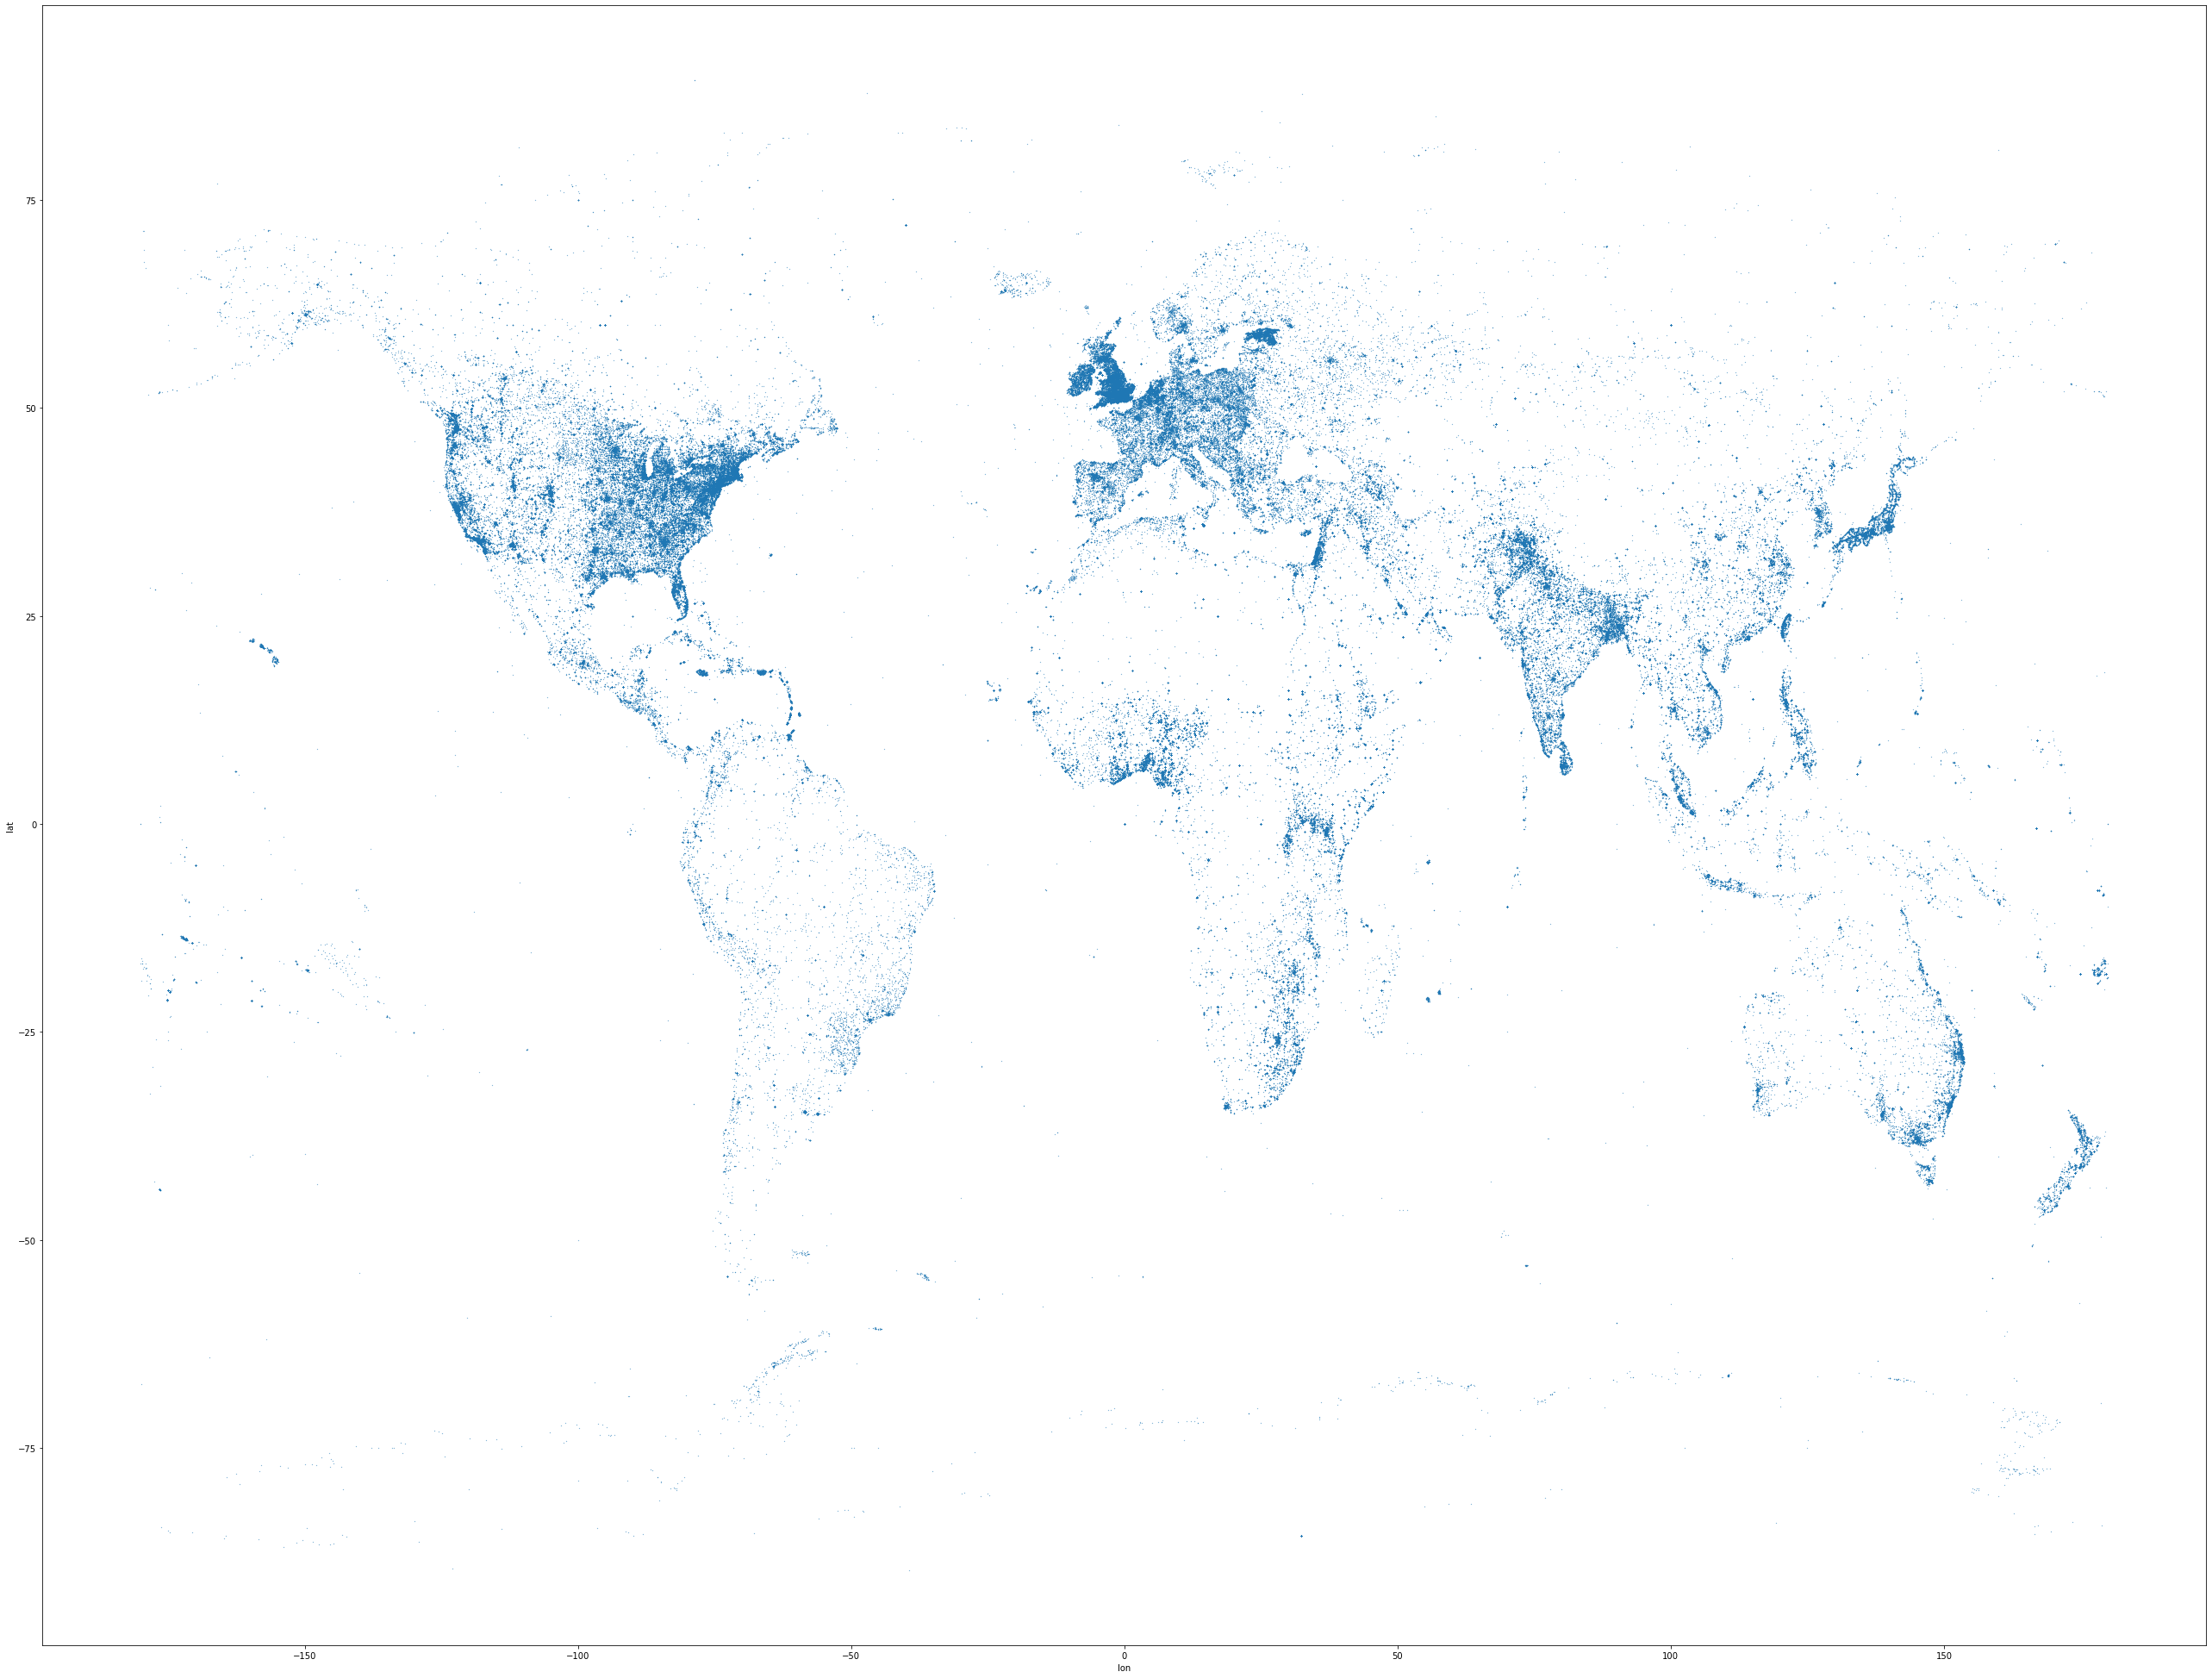

In [7]:
df_union.plot.scatter(x='lon', y='lat', figsize = (45,35), s=0.05)

In [8]:
# df_union.to_parquet("data/geo_data.parquet")
df_union = pd.read_parquet("data/geo_data.parquet")

In [50]:
df_sample = df_union.sample(frac=.25)

In [51]:
df_sample.shape[0]/df_union.shape[0]

0.24999977860373346

In [12]:
df_sample.plot.scatter(x='lon', y='lat', figsize = (45,35), s=0.05)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='lon', ylabel='lat'>

In [52]:
from transformers import DistilBertTokenizerFast
TOKEN_MODEL = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(TOKEN_MODEL)

In [53]:
tokenized_data = tokenizer(df_sample["text"].values.tolist(), truncation=True, padding=True)

In [54]:
labels = df_sample[['lat', 'lon']].values.astype(float).tolist()

In [55]:
from utils.utils import GEODataset

In [56]:
dataset = GEODataset(tokenized_data, labels)

In [57]:
import webdataset as wds
import sys

In [58]:
sink = wds.TarWriter("data/geo_wds.tar")
for index, enc in enumerate(dataset):
    if index%1000==0:
        print(f"{index:6d}", end="\r", flush=True, file=sys.stderr)
    sink.write({
        "__key__": "sample%06d" % index,
        "enc_dict.pyd": enc,
    })
sink.close()

In [60]:
!ls -l data/geo_wds.tar
!tar tvf data/geo_wds.tar | head

-rw-r--r--  1 hhoferic  staff  3179816960 Nov 19 18:23 data/geo_wds.tar
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000000.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000001.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000002.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000003.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000004.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000005.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000006.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000007.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000008.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000009.batch.pyd


In [61]:
webds = wds.WebDataset('data/geo_wds.tar').decode('torch')

In [62]:
import torch

In [63]:
dataloader = torch.utils.data.DataLoader(webds, num_workers=1, batch_size=16)

In [64]:
for index, batch in enumerate(dataloader):
    if index%10000==0:
        print(batch['batch.pyd']['labels'])

tensor([[ 31.7667,  35.2333],
        [ 33.8333,  35.8333],
        [ 10.5000, -66.9167],
        [ 39.9289, 116.3880],
        [ 52.5000,   5.7500],
        [ 39.8282, -98.5795],
        [ 38.8951, -77.0364],
        [ 40.7834, -73.9662],
        [ 25.2522,  55.2800],
        [ 20.0000,  77.0000],
        [ 46.0000,   2.0000],
        [ 46.2888, -96.9170],
        [ -2.0000, -77.5000],
        [ 35.0000, 105.0000],
        [ 25.0000,  45.0000],
        [ 42.9586, -78.4039]])
tensor([[ 22.5372,  59.7950],
        [ 51.8333,   0.5833],
        [ 39.2904, -76.6122],
        [ 16.0000, 106.0000],
        [ 39.0194, 125.7550],
        [ 42.3584, -71.0598],
        [ 30.0500,  31.2500],
        [ 32.0000,  90.0000],
        [ 39.9289, 116.3880],
        [ 16.1667, 107.8333],
        [  7.3878,   3.8964],
        [ 31.5000,  34.7500],
        [ 14.6042, 120.9820],
        [  1.3667, 103.8000],
        [ 44.4333,  26.1000],
        [ 54.5168,  -1.3424]])
